In [1]:
# collect the rvip detection experiments dataframes and create plots

In [4]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and some other standard libs to keep this cell clean
# local imports
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Preprocess import get_ip_from_mask_3d
from src.models.evaluate_cv import calc_tpr_thresh as calc_tpr
from src.models.evaluate_cv import calc_ppv_thresh as calc_ppv
from src.models.evaluate_cv import get_diffs, get_ip_from_rvip_file, get_dist, get_distances, get_mean_dist, get_distances_upper_bound


# import external libs
import os, glob
import cv2
import pandas as pd
import numpy as np
import SimpleITK as sitk
from ipyfilechooser import FileChooser

import matplotlib
plt.rcParams.update({'font.size': 15})
pd.options.display.float_format = '{:,.2f}'.format

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/wft21_septum_landmark_detection


# 1. Load one Experiment dataframe

In [5]:
df_chooser=FileChooser(os.getcwd())
display(df_chooser)

FileChooser(path='/mnt/ssd/git/wft21_septum_landmark_detection', filename='', title='HTML(value='', layout=Lay…

In [6]:
df = pd.read_csv(df_chooser.selected)
df.head()

,files_pred,files_io,files_orig_msk,files_gt,patient,phase,pathology,spacing,inplane_spacing,ips_pred,...,mdists_ant_gtpred_slice_wise_single_also,mdists_inf_gtpred_slice_wise_single_also,dists_ant_gtpred_up,dists_inf_gtpred_up,mdists_ant_gtpred_slice_wise_up,mdists_inf_gtpred_slice_wise_up,dists_ant_gtpred_single_also_up,dists_inf_gtpred_single_also_up,mdists_ant_gtpred_slice_wise_single_also_up,mdists_inf_gtpred_slice_wise_single_also_up
0,/mnt/ssd/git/wft21_septum_landmark_detection/e...,/mnt/ssd/data/acdc/wft2021/rvip/io/patient001_...,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,/mnt/ssd/git/wft21_septum_landmark_detection/e...,patient001,ED,DCM,"(1.5625, 1.5625, 10.0)",1.56,"([None, [113.83870967741936, 77.87096774193549...",...,3.37,2.38,[None 4.440063618053483 3.8067732951418263 1.8...,[None 4.334197129451376 3.3705556358246715 1.2...,152.04,160.76,[None 4.440063618053483 3.8067732951418263 1.8...,[None 4.334197129451376 3.3705556358246715 1.2...,152.04,2.38
1,/mnt/ssd/git/wft21_septum_landmark_detection/e...,/mnt/ssd/data/acdc/wft2021/rvip/io/patient001_...,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,/mnt/ssd/git/wft21_septum_landmark_detection/e...,patient001,ES,DCM,"(1.5625, 1.5625, 10.0)",1.56,"([None, [116.72727272727273, 78.95454545454545...",...,0.85,1.64,[None None 1.0168907005167938 0.39062500000000...,[None None 2.546829338992449 1.228637311529248...,0.85,1.64,[None None 1.0168907005167938 0.39062500000000...,[None None 2.546829338992449 1.228637311529248...,0.85,1.64
2,/mnt/ssd/git/wft21_septum_landmark_detection/e...,/mnt/ssd/data/acdc/wft2021/rvip/io/patient002_...,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,/mnt/ssd/git/wft21_septum_landmark_detection/e...,patient002,ED,DCM,"(1.3671875, 1.3671875, 10.0)",1.37,"([[110.41379310344827, 76.03448275862068], [11...",...,3.20,1.14,[2.8384685496883675 0.8544921875 1.52856209399...,[0.9385421047287325 1.2884705080055143 0.36951...,47.48,46.64,[2.8384685496883675 0.8544921875 1.52856209399...,[0.9385421047287325 1.2884705080055143 0.36951...,47.48,1.14
3,/mnt/ssd/git/wft21_septum_landmark_detection/e...,/mnt/ssd/data/acdc/wft2021/rvip/io/patient002_...,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,/mnt/ssd/git/wft21_septum_landmark_detection/e...,patient002,ES,DCM,"(1.3671875, 1.3671875, 10.0)",1.37,"([[114.7, 79.73333333333333], [109.88235294117...",...,1.97,2.21,[None 3.0348284891726105 0.9022977155765877 No...,[None 2.4556454453622 1.9697074079693986 None ...,1.97,2.21,[None 3.0348284891726105 0.9022977155765877 No...,[None 2.4556454453622 1.9697074079693986 None ...,1.97,2.21
4,/mnt/ssd/git/wft21_septum_landmark_detection/e...,/mnt/ssd/data/acdc/wft2021/rvip/io/patient003_...,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,/mnt/ssd/git/wft21_septum_landmark_detection/e...,patient003,ES,DCM,"(1.5625, 1.5625, 10.0)",1.56,"([None, [100.8, 117.1], [101.8, 115.08], [103....",...,4.18,0.82,[None None 1.2562344526401066 1.17320290410874...,[None None 0.1616379310344751 0.83437536575366...,4.18,0.82,[None None 1.2562344526401066 1.17320290410874...,[None None 0.1616379310344751 0.83437536575366...,4.18,0.82


## Column description

- **File paths for the predictions, rvip-inter-observer-gt, orig-acdc-masks, and rvip-gt:**

'files_pred', 'files_io', 'files_orig_msk', 'files_gt',

- **patient id, cardiac phase, pathology, CMR spacings and experiment name:**

'patient', 'phase', 'pathology', 'spacing', 'inplane_spacing', 'EXP'


- **Right ventricular insertion points (RVIP) as lists per 3D vol:**

'ips_pred','ips_gt', 'ips_io', 'ips_orig_msk', 'ips_pred_single_also',


- **Mean RVIP and septums angle per 3D vol:**

'mips_pred', 'mips_gt', 'mips_io','mips_orig_msk', 'mips_pred_single_also', 'mangle_pred', 'mangle_gt', 'mangle_io', 'mangle_orig_msk', 

- **Differences and mean difference between two angles (volume or slice-based):**

'diffs_gtpred','diffs_gtio', 'diffs_gtorig','mdiffs_gtpred', 'mdiffs_gtio', 'mdiffs_gtorig',

- **Distances (slice-wise) and mean distance (per volume) per ant/inf IP-pairs (pred,gt,io), allow/discard single point predictions, with upper limit/without:**

'dists_ant_gtpred', 'dists_inf_gtpred', 'dists_inf_gtpred','dists_ant_gtio','dists_inf_gtio', 'dists_ant_gtorig', 'dists_inf_gtorig', 'dists_ant_gtpred_single_also', 'dists_inf_gtpred_single_also',  'dists_ant_gtpred_up','dists_inf_gtpred_up','dists_ant_gtpred_single_also_up',
'dists_inf_gtpred_single_also_up', 
'mdists_ant_gtpred', 'mdists_inf_gtpred', 'mdists_ant_gtio','mdists_inf_gtio', 'mdists_ant_gtorig', 'mdists_inf_gtorig', 'mdists_ant_gtpred_single_also','mdists_inf_gtpred_single_also', 'mdists_ant_gtpred_slice_wise', 'mdists_inf_gtpred_slice_wise', 'mdists_ant_gtpred_slice_wise_single_also','mdists_inf_gtpred_slice_wise_single_also', 'mdists_ant_gtpred_slice_wise_up',
'mdists_inf_gtpred_slice_wise_up', 'mdists_ant_gtpred_slice_wise_single_also_up','mdists_inf_gtpred_slice_wise_single_also_up'

- **Septums angle of each slice as list:**

'angles_pred', 'angles_gt', 'angles_io', 'angles_orig_msk',

- **True positive rates (TPR) and positive predictive value (PPV) per ant/inf IP:**

'tpr_ant', 'tpr_inf', 'tpr_ant_io','tpr_inf_io', 'tpr_ant_msk', 'tpr_inf_msk', 'ppv_ant', 'ppv_inf',
'ppv_ant_io', 'ppv_inf_io', 'ppv_ant_msk', 'ppv_inf_msk',
 'tpr_ant_point', 'tpr_inf_point',
'ppv_ant_point', 'ppv_inf_point', 'tpr_ant_point_th15',
'tpr_inf_point_th15', 'ppv_ant_point_th15', 'ppv_inf_point_th15',


In [7]:
df.columns

Index(['files_pred', 'files_io', 'files_orig_msk', 'files_gt', 'patient',
       'phase', 'pathology', 'spacing', 'inplane_spacing', 'ips_pred',
       'ips_gt', 'ips_io', 'ips_orig_msk', 'mips_pred', 'mips_gt', 'mips_io',
       'mips_orig_msk', 'mangle_pred', 'mangle_gt', 'mangle_io',
       'mangle_orig_msk', 'mdiffs_gtpred', 'mdiffs_gtio', 'mdiffs_gtorig',
       'mdists_ant_gtpred', 'mdists_inf_gtpred', 'mdists_ant_gtio',
       'mdists_inf_gtio', 'mdists_ant_gtorig', 'mdists_inf_gtorig',
       'angles_pred', 'angles_gt', 'angles_io', 'angles_orig_msk',
       'dists_ant_gtpred', 'dists_inf_gtpred', 'dists_ant_gtio',
       'dists_inf_gtio', 'dists_ant_gtorig', 'dists_inf_gtorig',
       'diffs_gtpred', 'diffs_gtio', 'diffs_gtorig', 'EXP', 'tpr_ant',
       'tpr_inf', 'tpr_ant_io', 'tpr_inf_io', 'tpr_ant_msk', 'tpr_inf_msk',
       'ppv_ant', 'ppv_inf', 'ppv_ant_io', 'ppv_inf_io', 'ppv_ant_msk',
       'ppv_inf_msk', 'ips_pred_single_also', 'tpr_ant_point', 'tpr_inf_point',
     

# 2. Check for NaNs

In [8]:
# check for Nan
print(df.isnull().sum().sum())
df[df.isna().any(axis=1)]

3


,files_pred,files_io,files_orig_msk,files_gt,patient,phase,pathology,spacing,inplane_spacing,ips_pred,...,mdists_ant_gtpred_slice_wise_single_also,mdists_inf_gtpred_slice_wise_single_also,dists_ant_gtpred_up,dists_inf_gtpred_up,mdists_ant_gtpred_slice_wise_up,mdists_inf_gtpred_slice_wise_up,dists_ant_gtpred_single_also_up,dists_inf_gtpred_single_also_up,mdists_ant_gtpred_slice_wise_single_also_up,mdists_inf_gtpred_slice_wise_single_also_up
124,/mnt/ssd/git/wft21_septum_landmark_detection/e...,/mnt/ssd/data/acdc/wft2021/rvip/io/patient063_...,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,/mnt/ssd/git/wft21_septum_landmark_detection/e...,patient063,ES,NOR,"(1.3671875, 1.3671875, 10.0)",1.37,"([None, [65.175, 138.15], None, None, None, No...",...,nan,3.19,[None None 280.60669973128233 278.006744961593...,[None None 248.0983890897829 247.2039843438779...,275.18,245.68,[None None 280.60669973128233 278.006744961593...,[None None 3.1933175688076574 247.203984343877...,275.18,164.05


# 3. Inspect the distribution for some metrics

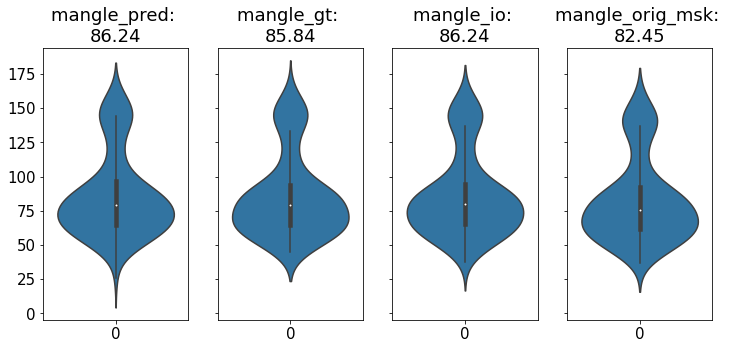

In [9]:
# angles per pre, gt, io and orig msk
cols = ['mangle_pred', 'mangle_gt', 'mangle_io',
       'mangle_orig_msk']
fig, axs = plt.subplots(1,len(cols), figsize=(len(cols)*3,5), sharey=True)
_ = [axs[i].set_title('{}: \n{:.2f}'.format(cols[i], df[cols[i]].mean())) for i in range(len(cols))]
_ = [sb.violinplot(data=df[cols[i]], ax=axs[i]) for i in range(len(cols))]

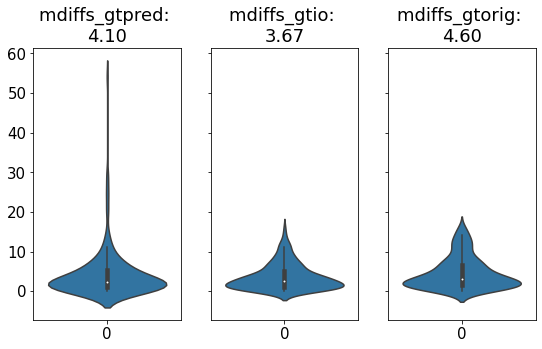

In [10]:
# angles per pre, gt, io and orig msk
cols = ['mdiffs_gtpred', 'mdiffs_gtio', 'mdiffs_gtorig']
fig, axs = plt.subplots(1,len(cols), figsize=(len(cols)*3,5), sharey=True)
_ = [axs[i].set_title('{}: \n{:.2f}'.format(cols[i], df[cols[i]].mean())) for i in range(len(cols))]
_ = [sb.violinplot(data=df[cols[i]], ax=axs[i]) for i in range(len(cols))]

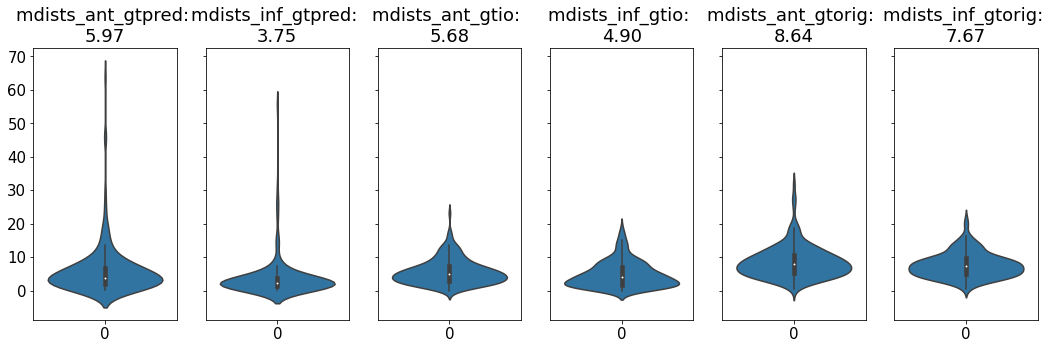

In [11]:
# distances ant and inf
cols = ['mdists_ant_gtpred', 'mdists_inf_gtpred', 'mdists_ant_gtio',
       'mdists_inf_gtio', 'mdists_ant_gtorig', 'mdists_inf_gtorig']
fig, axs = plt.subplots(1,len(cols), figsize=(len(cols)*3,5), sharey=True)
_ = [axs[i].set_title('{}: \n{:.2f}'.format(cols[i], df[cols[i]].mean())) for i in range(len(cols))]
_ = [sb.violinplot(data=df[cols[i]], ax=axs[i]) for i in range(len(cols))]

# 4. Print mean +/- std for volume based metrics

In [12]:
# initial
cols_diff = ['mdiffs_gtpred']
cols_dist = ['mdists_ant_gtpred', 'mdists_inf_gtpred', 'mdiffs_gtpred','tpr_ant', 'tpr_ant_io','tpr_ant_msk', 'ppv_ant', 'ppv_ant_io','ppv_ant_msk']
cols = cols_dist + cols_diff
print('mean:')
print(df[cols].mean())
print('+/- std')
print(df[cols].std())

mean:
mdists_ant_gtpred   5.97
mdists_inf_gtpred   3.75
mdiffs_gtpred       4.10
tpr_ant             0.90
tpr_ant_io          0.78
tpr_ant_msk         0.96
ppv_ant             0.84
ppv_ant_io          0.83
ppv_ant_msk         0.67
mdiffs_gtpred       4.10
dtype: float64
+/- std
mdists_ant_gtpred   7.45
mdists_inf_gtpred   5.79
mdiffs_gtpred       5.93
tpr_ant             0.17
tpr_ant_io          0.25
tpr_ant_msk         0.09
ppv_ant             0.21
ppv_ant_io          0.23
ppv_ant_msk         0.23
mdiffs_gtpred       5.93
dtype: float64


# 5. Inspect single columns

In [13]:
df['mangle_pred']

0      68.12
1      69.82
2      60.21
3      63.42
4     123.11
       ...  
195    51.16
196    64.33
197    65.22
198    92.78
199    94.76
Name: mangle_pred, Length: 200, dtype: float64

# 6. Create Scatterplots, calculate single pearson correlations and create correlation heatmaps

In [14]:
from scipy.stats.stats import pearsonr
pearsonr(df['mangle_pred'].values, df['mangle_gt'].values)

(0.9723925733034038, 4.275647218416051e-127)

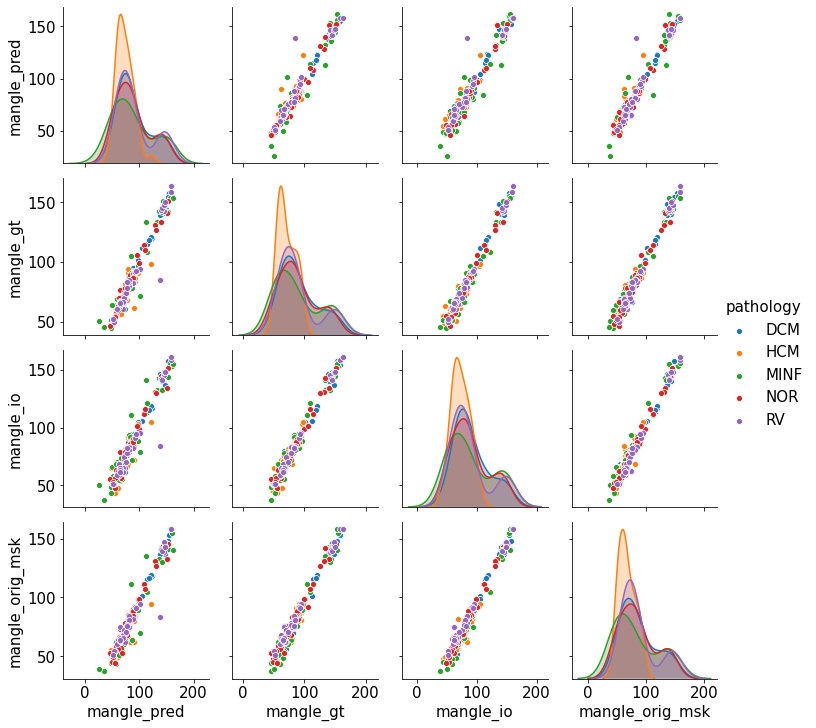

In [15]:
# correlation scatterplots of the angles
cols = ['mangle_pred', 'mangle_gt', 'mangle_io',
       'mangle_orig_msk', 'pathology']
sb.pairplot(data =df[cols], hue='pathology')

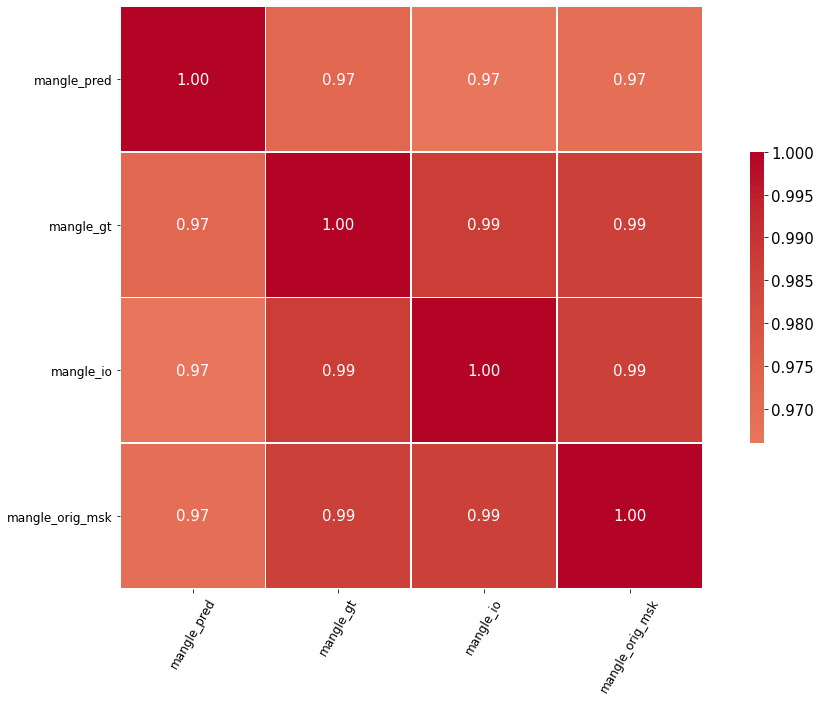

In [16]:
fig, ax = plt.subplots(figsize=(14,10))
corr = df[cols].corr(method='pearson')
g = sb.heatmap(corr,  vmax=1, center=.9,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

# 7. Interactive cell filtering by threshold to identify outliers

In [17]:
# filter the df_angles dataframe by specific values
@interact
def inspect_angle_df_interact(greater_as='0', col=df.columns):
    greater_as = float(greater_as)
    try:
        df_filter = df[df[col]>=greater_as]
        print(df_filter[['patient','phase','mangle_pred', 'mangle_gt'] + [col]])
        return df_filter
    except:
        pass

interactive(children=(Text(value='0', description='greater_as'), Dropdown(description='col', options=('files_p…

# 8. Interactive visualisations of our predictions

In [42]:
from src.visualization.Visualize import plot_dice_per_slice_bar
from src.data.Preprocess import transform_to_binary_mask
@interact
def show_outlier(pat=df.patient.unique(), phase=['ED', 'ES'], compare_with=['files_io', 'files_pred']):
    global gt, pred, cmr
    temp = df[(df['patient']==pat) & (df['phase']==phase)][['files_gt', 'files_orig_msk', 'files_pred', 'files_io']]
    print(temp.values)
    gt = sitk.GetArrayFromImage(sitk.ReadImage(temp['files_gt'].values[0]))
    pred = sitk.GetArrayFromImage(sitk.ReadImage(temp[compare_with].values[0]))
    
    cmr = sitk.GetArrayFromImage(sitk.ReadImage(temp['files_pred'].values[0].replace('msk','cmr')))
    gt_b, pred_b = transform_to_binary_mask(gt,mask_values=[1,2]).astype(np.float32), transform_to_binary_mask(pred,mask_values=[1,2]).astype(np.float32)
    print('GT')
    show_2D_or_3D(cmr, gt_b);plt.show()
    print('PRED')
    show_2D_or_3D(cmr, pred_b)
    _ =plot_dice_per_slice_bar(gt_b,pred_b)
    

interactive(children=(Dropdown(description='pat', options=('patient001', 'patient002', 'patient003', 'patient0…

# Example cells for further data extraction
* So that we can compute point-based vs. slice-based distance metrics

In [19]:
df[['ips_gt','ips_pred']]

,ips_gt,ips_pred
0,"([None, [111.0, 78.0], [112.0, 76.0], [112.0, ...","([None, [113.83870967741936, 77.87096774193549..."
1,"([None, None, [115.0, 80.0], [114.0, 76.0], [1...","([None, [116.72727272727273, 78.95454545454545..."
2,"([[110.0, 74.0], [111.0, 73.0], [114.0, 74.0],...","([[110.41379310344827, 76.03448275862068], [11..."
3,"([None, [108.0, 80.0], [116.0, 78.0], None, No...","([[114.7, 79.73333333333333], [109.88235294117..."
4,"([None, None, [101.0, 115.0], [103.0, 116.0], ...","([None, [100.8, 117.1], [101.8, 115.08], [103...."
...,...,...
195,"([[106.0, 88.0], [107.0, 82.0], [110.0, 84.0],...","([[104.02702702702703, 85.35135135135135], [10..."
196,"([None, [114.0, 57.0], [117.0, 59.0], None, No...","([None, [112.86363636363636, 57.31818181818182..."
197,"([[102.0, 56.0], [113.0, 57.0], [115.0, 60.0],...","([[95.5, 63.2], [111.52941176470588, 56.647058..."
198,"([[128.0, 95.0], [128.0, 95.0], [127.0, 94.0],...","([[126.23913043478261, 94.65217391304348], [12..."


In [20]:
# *************** Slice based
# TPR
# PPV
# *************** Point based
cols = ['tpr_ant', 'tpr_inf', 'ppv_ant', 'ppv_inf', 'tpr_ant_point', 'tpr_inf_point', 'ppv_ant_point', 'ppv_inf_point']
df[cols].mean(), df[cols].std()

(tpr_ant         0.90
 tpr_inf         0.99
 ppv_ant         0.84
 ppv_inf         0.84
 tpr_ant_point   0.92
 tpr_inf_point   1.00
 ppv_ant_point   0.79
 ppv_inf_point   0.78
 dtype: float64,
 tpr_ant         0.17
 tpr_inf         0.07
 ppv_ant         0.21
 ppv_inf         0.21
 tpr_ant_point   0.15
 tpr_inf_point   0.00
 ppv_ant_point   0.22
 ppv_inf_point   0.22
 dtype: float64)

### Compute PPV and TPR with threshold 
* Here there are two kinds of FP: First, if there is no GT and if there is any ip detected. Second if there is both pred and gt, but pred is farther away than the threshold distance, then it is also a FP

In [21]:
# *************** Point based with threshold=15mm
cols = ['tpr_ant_point_th15', 'tpr_inf_point_th15', 'ppv_ant_point_th15', 'ppv_inf_point_th15']
df[cols].mean(), df[cols].std()

(tpr_ant_point_th15   0.92
 tpr_inf_point_th15   0.99
 ppv_ant_point_th15   0.77
 ppv_inf_point_th15   0.77
 dtype: float64,
 tpr_ant_point_th15   0.16
 tpr_inf_point_th15   0.07
 ppv_ant_point_th15   0.23
 ppv_inf_point_th15   0.22
 dtype: float64)

### Volume based for 1 ip point also

In [22]:
# ---------------------
print('Slice-based for 2 IPs')
cols = ['mdists_ant_gtpred', 'mdists_inf_gtpred']
for i, (a, b) in enumerate(zip(df[cols].mean(), df[cols].std())):
    print("{}: {:.02f} ± {:.02f}".format(list(df[cols])[i], a, b))
    
# ---------------------

print('\nVolume-based for 1 IP also')
cols = ['mdists_ant_gtpred_single_also', 'mdists_inf_gtpred_single_also']
for i, (a, b) in enumerate(zip(df[cols].mean(), df[cols].std())):
    print("{}: {:.02f} ± {:.02f}".format(list(df[cols])[i], a, b))

Slice-based for 2 IPs
mdists_ant_gtpred: 5.97 ± 7.45
mdists_inf_gtpred: 3.75 ± 5.79

Volume-based for 1 IP also
mdists_ant_gtpred_single_also: 7.62 ± 9.51
mdists_inf_gtpred_single_also: 5.27 ± 8.51


### Distances for 1 and 2 IPs

In [23]:
# For 2 IPS detected only
print('Slice-based for 2 IPs')
cols = ['mdists_ant_gtpred_slice_wise', 'mdists_inf_gtpred_slice_wise']
for i, (a, b) in enumerate(zip(df[cols].mean(), df[cols].std())):
    print("{}: {:.02f} ± {:.02f}".format(list(df[cols])[i], a, b))
# ---------------------
# For 1 IPS detected also
print('\nSlice-based for 1 IPs also')
cols = ['mdists_ant_gtpred_slice_wise_single_also', 'mdists_inf_gtpred_slice_wise_single_also']
for i, (a, b) in enumerate(zip(df[cols].mean(), df[cols].std())):
    print("{}: {:.02f} ± {:.02f}".format(list(df[cols])[i], a, b))

Slice-based for 2 IPs
mdists_ant_gtpred_slice_wise: 4.09 ± 7.41
mdists_inf_gtpred_slice_wise: 2.68 ± 4.57

Slice-based for 1 IPs also
mdists_ant_gtpred_slice_wise_single_also: 4.30 ± 8.15
mdists_inf_gtpred_slice_wise_single_also: 2.82 ± 4.98


In [24]:
# For 2 IPS detected only
# ---------------------
print('Slice-based for 2 IPs')
cols = ['mdists_ant_gtpred_slice_wise_up', 'mdists_inf_gtpred_slice_wise_up']
for i, (a, b) in enumerate(zip(df[cols].mean(), df[cols].std())):
    print("{}: {:.02f} ± {:.02f}".format(list(df[cols])[i], a, b))
# ---------------------

Slice-based for 2 IPs
mdists_ant_gtpred_slice_wise_up: 33.03 ± 48.39
mdists_inf_gtpred_slice_wise_up: 32.10 ± 49.41


In [25]:
# For 1 IPS detected also
# ---------------------
print('\nSlice-based for 1 IPs also')
cols = ['mdists_ant_gtpred_slice_wise_single_also_up', 'mdists_inf_gtpred_slice_wise_single_also_up']
for i, (a, b) in enumerate(zip(df[cols].mean(), df[cols].std())):
    print("{}: {:.02f} ± {:.02f}".format(list(df[cols])[i], a, b))


Slice-based for 1 IPs also
mdists_ant_gtpred_slice_wise_single_also_up: 26.82 ± 43.46
mdists_inf_gtpred_slice_wise_single_also_up: 15.81 ± 32.77


### Angle computation
* No change here, just reproducing

In [26]:
print("mdiffs_gtpred: {:.02f} ± {:.02f}".format(df['mdiffs_gtpred'].mean(), df['mdiffs_gtpred'].std()))

mdiffs_gtpred: 4.10 ± 5.93


End of notebook